In [1]:
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [3]:
gazew_dict = np.load("../results/gazew_animals_val.npz", allow_pickle=True)

In [4]:
labels = np.load("../results/attn_best_label_N2010.npy")

In [5]:
training_methods = ["dino", "supervised"] 
depth_list = [8, 12]
num_models = 6
num_heads = 6

In [6]:
tm = training_methods[0]
d_label = np.array([[7,8],[9,10]]) - 1

In [7]:
animal_gazew_dict = {}
for label in ["eye", "mouth"]:
    gazew_concat = []
    for i, depth in enumerate(depth_list):
        gazew = gazew_dict[tm].item()[str(depth)][label]
        for j in range(2):
            gazew_concat.append(np.mean(gazew[:, d_label[i,j]], axis=-1).flatten())
    animal_gazew_dict[label] = np.hstack(gazew_concat) * 100

In [8]:
labels_ = 1*(labels == 1) + 2*(labels == 3) + 3*(labels == 2)

In [9]:
import pandas as pd

In [10]:
gazew_parts_vit_data = np.load("../results/gazew_parts_vit_N2010.npz", allow_pickle=True)

In [11]:
gazew_parts_vit_data.files

['gazew_parts', 'object_labels']

In [12]:
object_labels = gazew_parts_vit_data["object_labels"]

In [13]:
clip_indices = np.array([3,7,11]) - 1 

In [14]:
gazew_parts_vit_means = {}
for tm in training_methods:
    gazew_parts_vit_means[tm] = {}
    for depth in depth_list:
        gazew_parts_vit_means[tm][str(depth)] = {}
        gazew_parts_vit_depth = gazew_parts_vit_data['gazew_parts'].item()[tm][str(depth)]
        for obj_idx, obj_label in enumerate(object_labels):
            if obj_label == "eye" or "mouth" or "face":
                gazew_parts_vit_depth_mean = np.nanmean(gazew_parts_vit_depth[:, :, :, clip_indices, obj_idx], axis=3)
                gazew_parts_vit_means[tm][str(depth)][obj_label] = gazew_parts_vit_depth_mean#.transpose(1, 0, 2).reshape(depth, -1)

/tmp/ipykernel_40235/2748043383.py:9: RuntimeWarning: Mean of empty slice
  gazew_parts_vit_depth_mean = np.nanmean(gazew_parts_vit_depth[:, :, :, clip_indices, obj_idx], axis=3)


In [15]:
"""
head_GMM_label = np.load("../results/head_GMM_label.npz", allow_pickle=True)
layer_indices = head_GMM_label["layer_indices"].astype(int)
label_rank = head_GMM_label["label_rank"].astype(int)
head_label = head_GMM_label["head_label"].astype(int)
head_label_proba = head_GMM_label["head_label_proba"]
num_groups = len(np.unique(label_rank))
"""
head_label = np.load("../results/attn_best_label_N2010.npy").astype(int).reshape(4, 6, 6)

In [16]:
"""
gazew_parts_vit_bh_means = {}
for obj_idx, obj_label in enumerate(object_labels):
    gazew_parts_vit_bh_means[obj_label] = []

tm = training_methods[0]
for i, depth in enumerate(depth_list):
    d_indices = layer_indices[layer_indices[:, 0] == depth][:,1]
    for obj_idx, obj_label in enumerate(object_labels):
        gazew_parts_obj = gazew_parts_vit_means[tm][str(depth)][obj_label]
        for m_idx in range(num_models):
            for j, d_idx in enumerate(d_indices):
                for h_idx in range(num_heads):
                    gazew_parts_vit_bh_means[obj_label].append(gazew_parts_obj[m_idx, d_idx, h_idx])
"""

'\ngazew_parts_vit_bh_means = {}\nfor obj_idx, obj_label in enumerate(object_labels):\n    gazew_parts_vit_bh_means[obj_label] = []\n\ntm = training_methods[0]\nfor i, depth in enumerate(depth_list):\n    d_indices = layer_indices[layer_indices[:, 0] == depth][:,1]\n    for obj_idx, obj_label in enumerate(object_labels):\n        gazew_parts_obj = gazew_parts_vit_means[tm][str(depth)][obj_label]\n        for m_idx in range(num_models):\n            for j, d_idx in enumerate(d_indices):\n                for h_idx in range(num_heads):\n                    gazew_parts_vit_bh_means[obj_label].append(gazew_parts_obj[m_idx, d_idx, h_idx])\n'

In [17]:
object_labels

array(['obj', 'eye', 'mouth', 'nose', 'ear', 'face', 'hand'], dtype='<U5')

In [18]:
gazew_human = []
tm = training_methods[0]
for i, depth in enumerate(depth_list):
    gazew = gazew_parts_vit_means[tm][str(depth)]["face"]
    #gazew = gazew_parts_vit_means[tm][str(depth)]["eye"]
    #gazew += gazew_parts_vit_means[tm][str(depth)]["mouth"]
    for j in range(2):
        gazew_human.append(gazew[:, d_label[i,j]].flatten())

gazew_human = np.hstack(gazew_human)

In [19]:
gazew_concat = animal_gazew_dict["eye"] + animal_gazew_dict["mouth"]

In [20]:
from scipy.stats import pearsonr

In [21]:
r_s, p = pearsonr(gazew_human, gazew_concat)

In [22]:
r_s, p

(0.7487768747848489, 3.861193336312359e-27)

In [23]:
df = pd.DataFrame(np.c_[gazew_human, gazew_concat, labels_], columns=["human_gazew", "animal_gazew", "label"])

In [24]:
df 

,human_gazew,animal_gazew,label
0,92.449541,90.217566,1.0
1,3.103748,24.131346,3.0
2,23.867255,49.734620,2.0
3,5.331124,23.115765,2.0
4,48.024298,63.427006,2.0
...,...,...,...
139,22.326217,50.640721,2.0
140,94.467496,95.423515,1.0
141,16.531513,48.368821,2.0
142,8.355441,16.534928,3.0


In [25]:
df[df["label"] == 1].median()

human_gazew     92.020091
animal_gazew    85.178277
label            1.000000
dtype: float64

In [26]:
#cols = ["#DC267F", "#648FFF", "#FFB000"]
cols = ["#56B4E9", "#FFB000", "#DC267F"]#"#DC267F", "#648FFF", "#FFB000"]
pal = {i+1: cols[i] for i in range(3)}

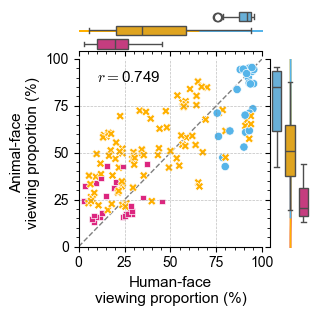

In [27]:
g = sns.jointplot(data=df, x="human_gazew", y="animal_gazew", hue="label", ratio=4, palette=pal, height=3.1, style=df["label"], legend=False)
#g = sns.JointGrid(data=df, x="human_gazew", y="animal_gazew", hue="label", height=3, palette=pal)
#g.plot_joint(sns.scatterplot, markers=markers)
g.plot_marginals(sns.boxplot, width=1, gap=0.3)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axline((0, 0), slope=1, color='tab:gray', linestyle='--', linewidth=1, zorder=-1)

plt.text(10, 90, r"$r=$"+f"{np.abs(r_s):.03f}", fontsize=11, ha="left", va="center",  math_fontfamily='cm')
#ax.set_xscale("log")
plt.xlabel("Human-face\nviewing proportion (%)", fontsize=11)
#plt.xlabel("Human-eye viewing proportion (%)", fontsize=11)
plt.ylabel("Animal-face\nviewing proportion (%)", fontsize=11)
#plt.tight_layout()
plt.xticks([0,25,50,75,100])
plt.yticks([0,25,50,75,100])
for loc in range(25, 100, 25):
    plt.axvline(loc, alpha=0.5, color='tab:gray', linestyle='--', linewidth=0.5)
    plt.axhline(loc, alpha=0.5, color='tab:gray', linestyle='--', linewidth=0.5)
"""
sns.move_legend(
    g.ax_joint, "lower right",
    title=None
)
"""
plt.minorticks_on()
plt.savefig(f"../figures/face_viewing_prop_human_animal.svg", dpi=300)